## 1. Dataset Preparation

### Clone ICRS Project

In [1]:
!git clone https://github.com/lhfazry/icrs

Cloning into 'icrs'...
remote: Enumerating objects: 719, done.
remote: Counting objects: 100% (719/719), done.
remote: Compressing objects: 100% (666/666), done.
remote: Total 719 (delta 99), reused 670 (delta 50), pack-reused 0 (from 0)
Receiving objects: 100% (719/719), 6.96 MiB | 13.83 MiB/s, done.
Resolving deltas: 100% (99/99), done.


In [2]:
%cd icrs

/content/icrs


### Download the Dataset

In [3]:
!./run_download_dataset.sh

Downloading...
From: https://drive.google.com/uc?id=1I6WY21iCs_XR8wFWM-79JRryp_9PunMT
To: /content/icrs/input_video.mp4
100% 65.1M/65.1M [00:01<00:00, 37.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1V3jDKzgbIKk1fLTpYWScM9O2h2o9pPh1
To: /content/icrs/icrs.zip
100% 6.54M/6.54M [00:00<00:00, 101MB/s]


### Setup and Configuration

In [ ]:
import json
import os
from collections import Counter
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import random
import numpy as np

BASE_DATASET_PATH = './data/detection'

SPLITS = ['train', 'valid', 'test']

### Helper Functions

In [ ]:
def load_coco_annotations(split_path):
    annotation_file = os.path.join(split_path, '_annotations.coco.json')
    if not os.path.exists(annotation_file):
        print(f"Warning: Annotation file not found at {annotation_file}")
        return None
    with open(annotation_file, 'r') as f:
        data = json.load(f)
    return data

def get_image_path(split_path, image_filename):
    image_path_in_split = os.path.join(split_path, image_filename)
    if os.path.exists(image_path_in_split):
        return image_path_in_split
    else:
        image_path_in_images_subfolder = os.path.join(split_path, 'images', image_filename)
        if os.path.exists(image_path_in_images_subfolder):
            return image_path_in_images_subfolder
        else:
            print(f"Warning: Image not found at {image_path_in_split} or {image_path_in_images_subfolder}")
            return None

## 2. Dataset Statistics

In [ ]:
print("--- Dataset Statistics: Number of Images per Split ---")

dataset_stats = {}

for split in SPLITS:
    print(f"\nProcessing split: {split}")
    split_path = os.path.join(BASE_DATASET_PATH, split)

    if not os.path.exists(split_path):
        print(f"Error: Split path not found: {split_path}. Skipping this split.")
        continue

    annotations = load_coco_annotations(split_path)
    if annotations is None:
        continue

    dataset_stats[split] = {}

    num_images = len(annotations['images'])
    dataset_stats[split]['num_images'] = num_images
    print(f"  Number of images: {num_images}")

print("\nNumber of Images per Split Calculation Complete.")

--- Dataset Statistics: Number of Images per Split ---

Processing split: train
  Number of images: 117

Processing split: valid
  Number of images: 17

Processing split: test
  Number of images: 18

Number of Images per Split Calculation Complete.


## 3. Class Distribution Analysis and Visualization


--- Class Distribution Analysis and Visualization ---

Analyzing class distribution for split: train
  Class distribution (top 10 for train):
    - MPV_SUV: 161
    - Box: 52
    - Minibus: 52
    - Bus: 38
    - Pickup-Truck: 27
    - Hatchback: 8
    - Bajaj: 7
    - Sedan: 3


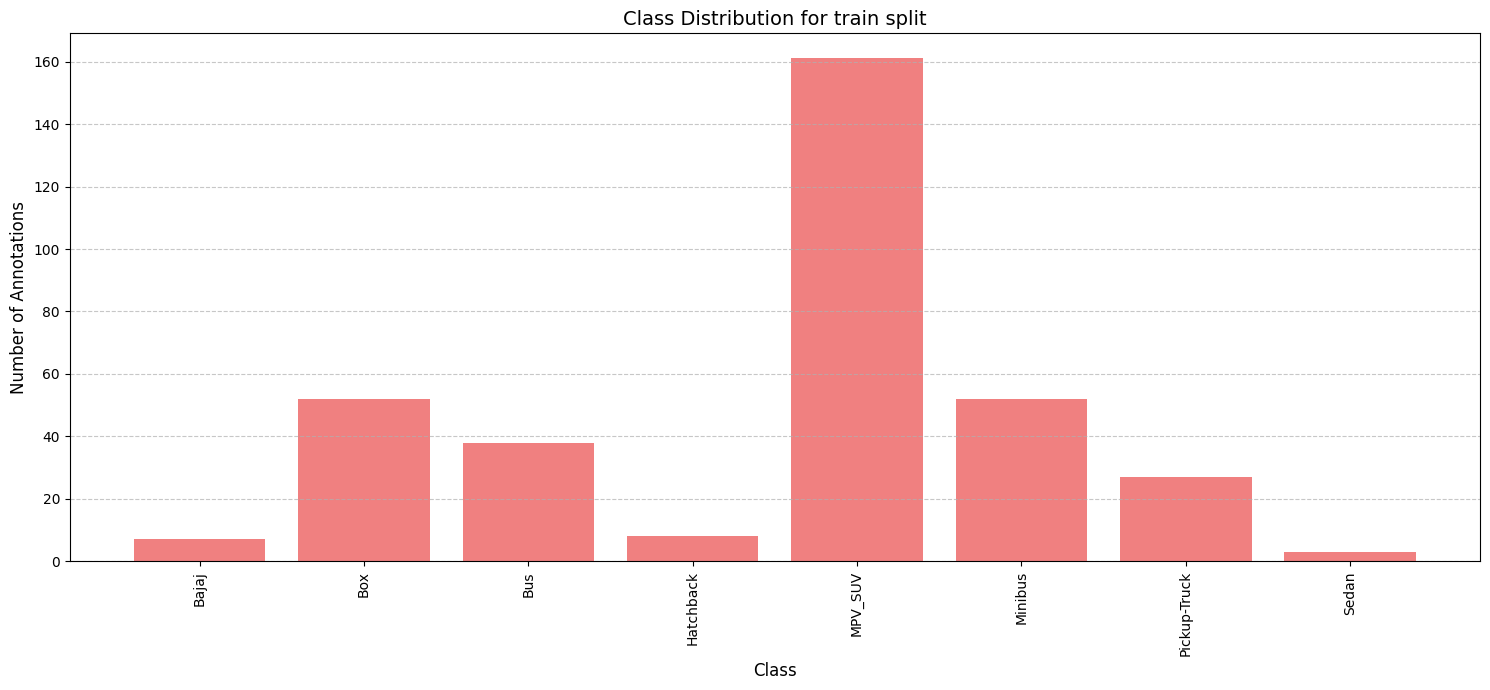


Analyzing class distribution for split: valid
  Class distribution (top 10 for valid):
    - MPV_SUV: 16
    - Bus: 5
    - Pickup-Truck: 4
    - Box: 3
    - Minibus: 2
    - Hatchback: 1
    - Bajaj: 1
    - Sedan: 1


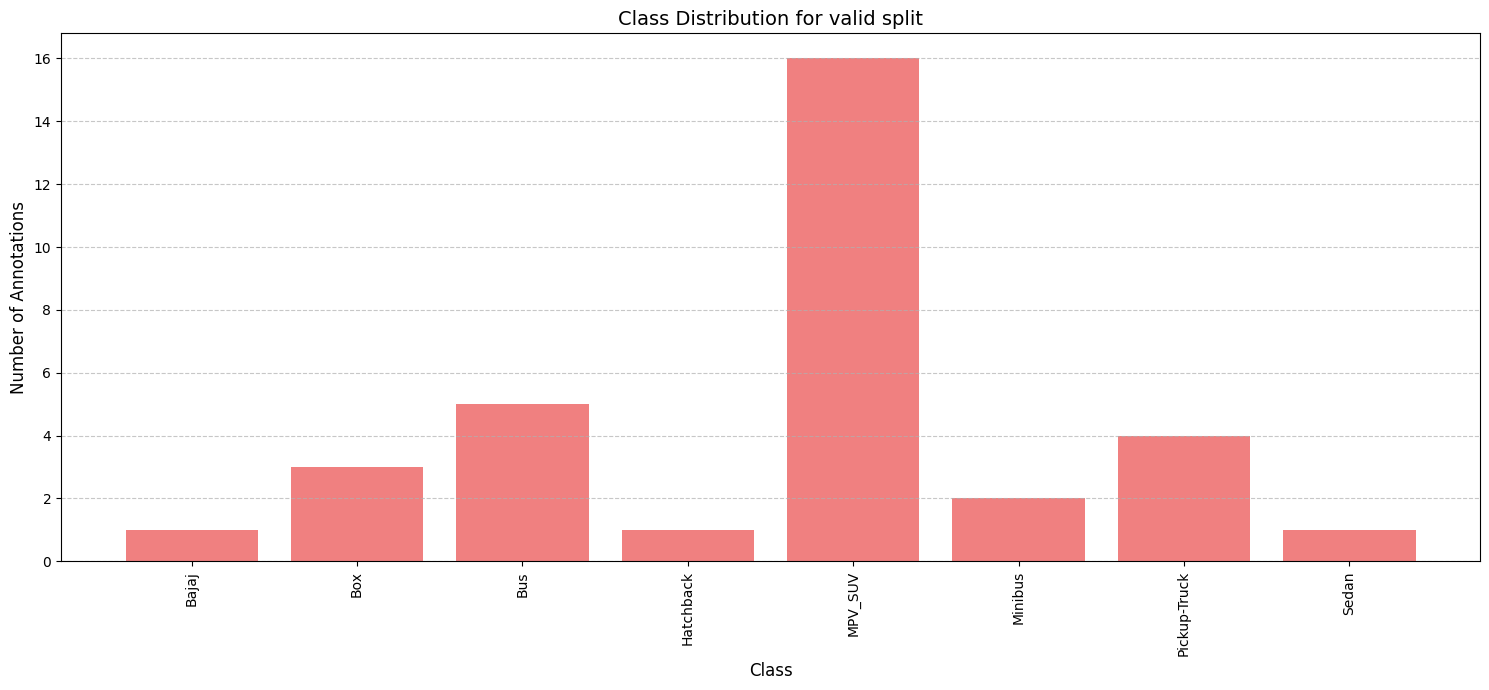


Analyzing class distribution for split: test
  Class distribution (top 10 for test):
    - MPV_SUV: 23
    - Minibus: 7
    - Bus: 6
    - Box: 4
    - Hatchback: 4
    - Pickup-Truck: 1
    - Sedan: 1
    - Bajaj: 1


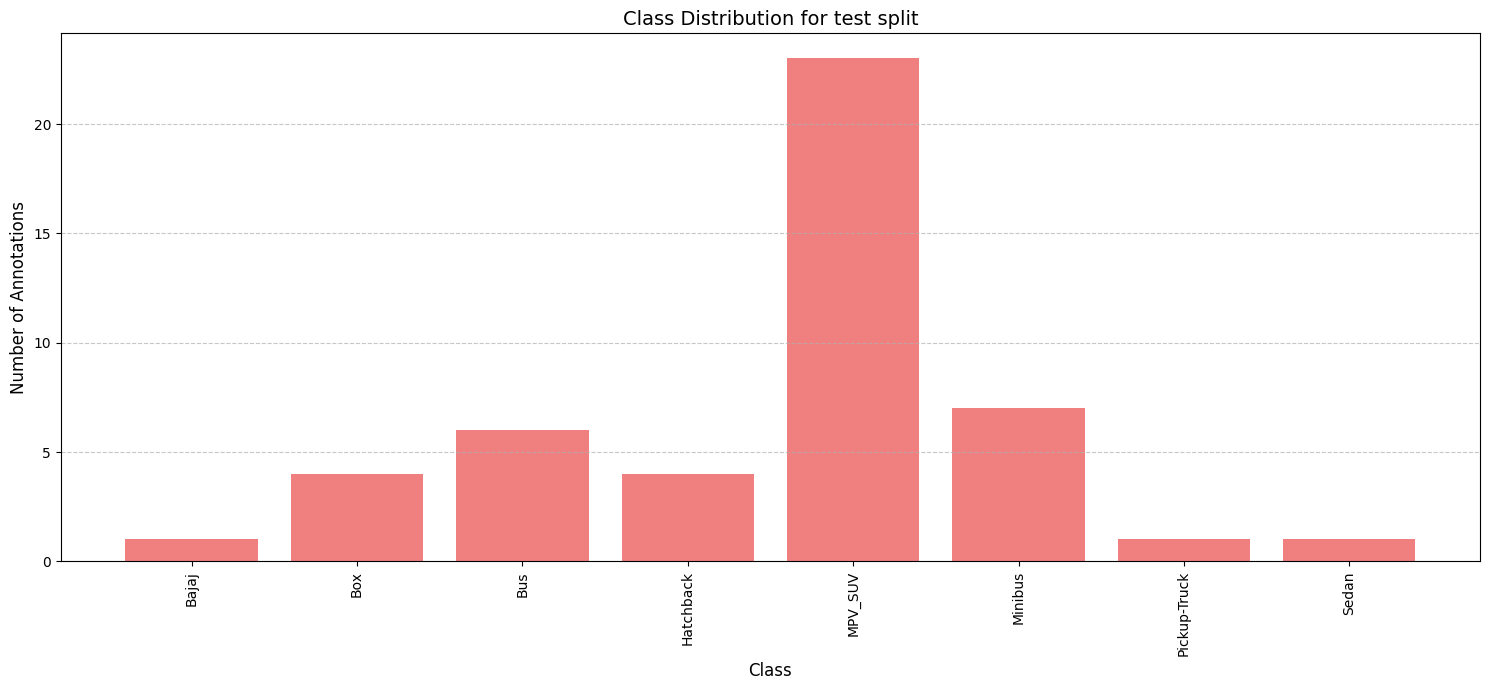

In [ ]:
print("\n--- Class Distribution Analysis and Visualization ---")

for split in SPLITS:
    print(f"\nAnalyzing class distribution for split: {split}")
    split_path = os.path.join(BASE_DATASET_PATH, split)

    annotations = load_coco_annotations(split_path)
    if annotations is None:
        continue

    category_id_to_name = {cat['id']: cat['name'] for cat in annotations['categories']}
    class_counts = Counter()

    for ann in annotations['annotations']:
        class_counts[category_id_to_name[ann['category_id']]] += 1

    dataset_stats[split]['class_counts'] = class_counts
    print(f"  Class distribution (top 10 for {split}):")
    for cls, count in class_counts.most_common(10):
        print(f"    - {cls}: {count}")

    if class_counts:
        sorted_classes = sorted(class_counts.keys())
        classes = [cls for cls in sorted_classes]
        counts = [class_counts[cls] for cls in sorted_classes]


        plt.figure(figsize=(15, 7))
        plt.bar(classes, counts, color='lightcoral')
        plt.xlabel('Class', fontsize=12)
        plt.ylabel('Number of Annotations', fontsize=12)
        plt.title(f'Class Distribution for {split} split', fontsize=14)
        plt.xticks(rotation=90, fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        print(f"  No annotations found for {split} split to plot class distribution.")

## 4. Visualize Sample Images


--- Visualization: Sample Images with Bounding Boxes ---

Displaying 9 sample images from train split...


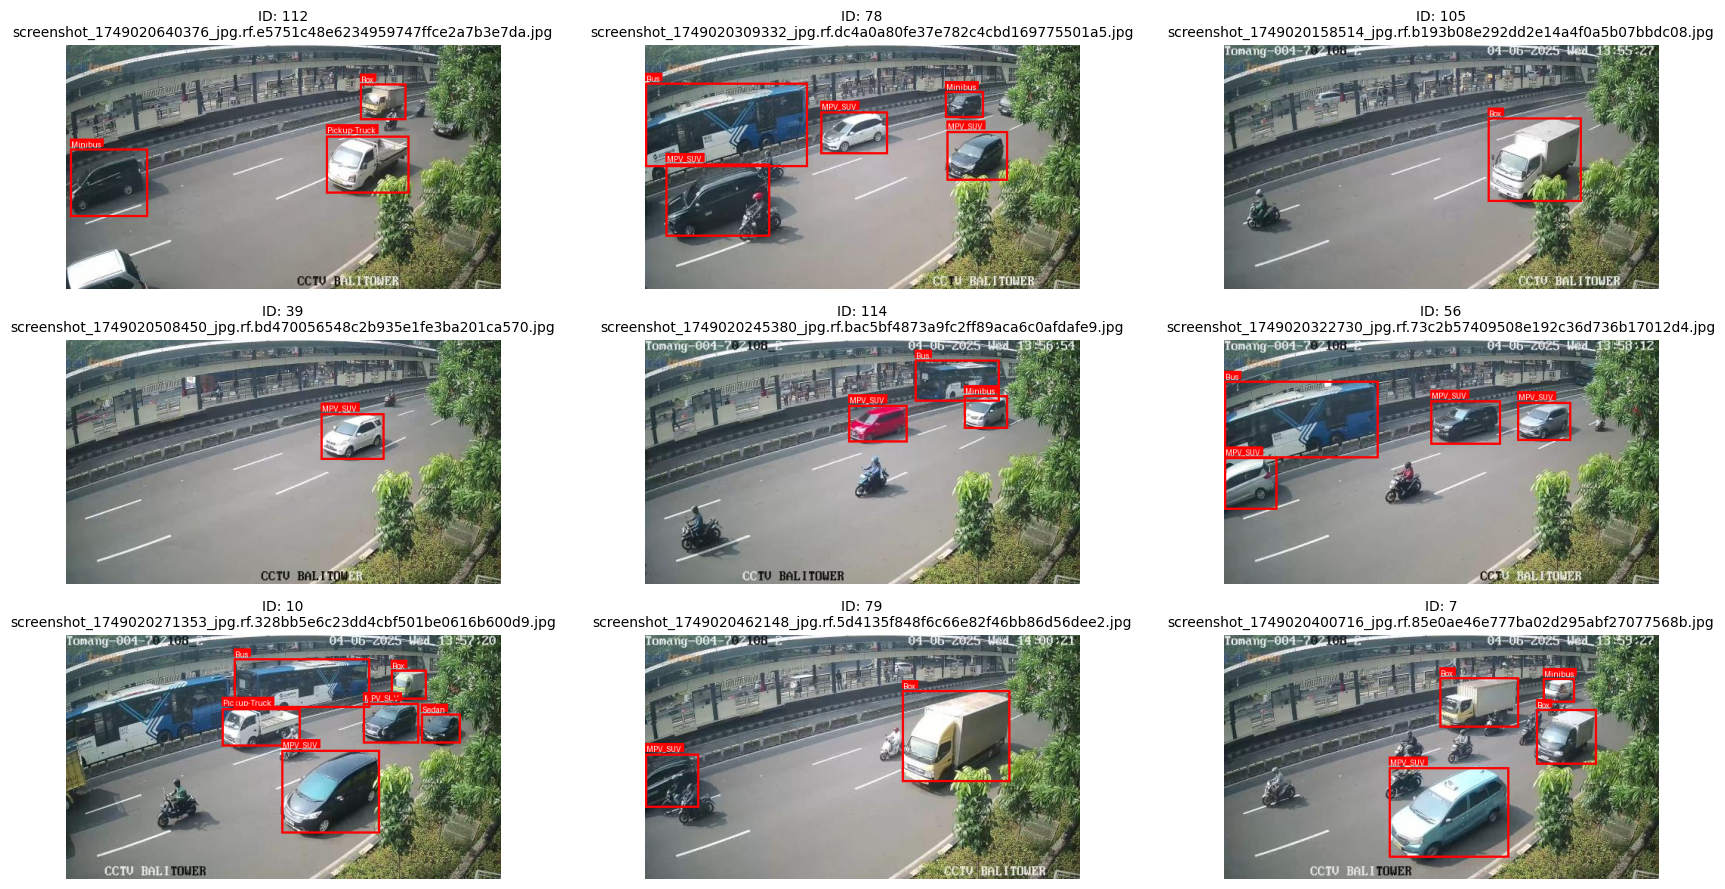


Displaying 9 sample images from valid split...


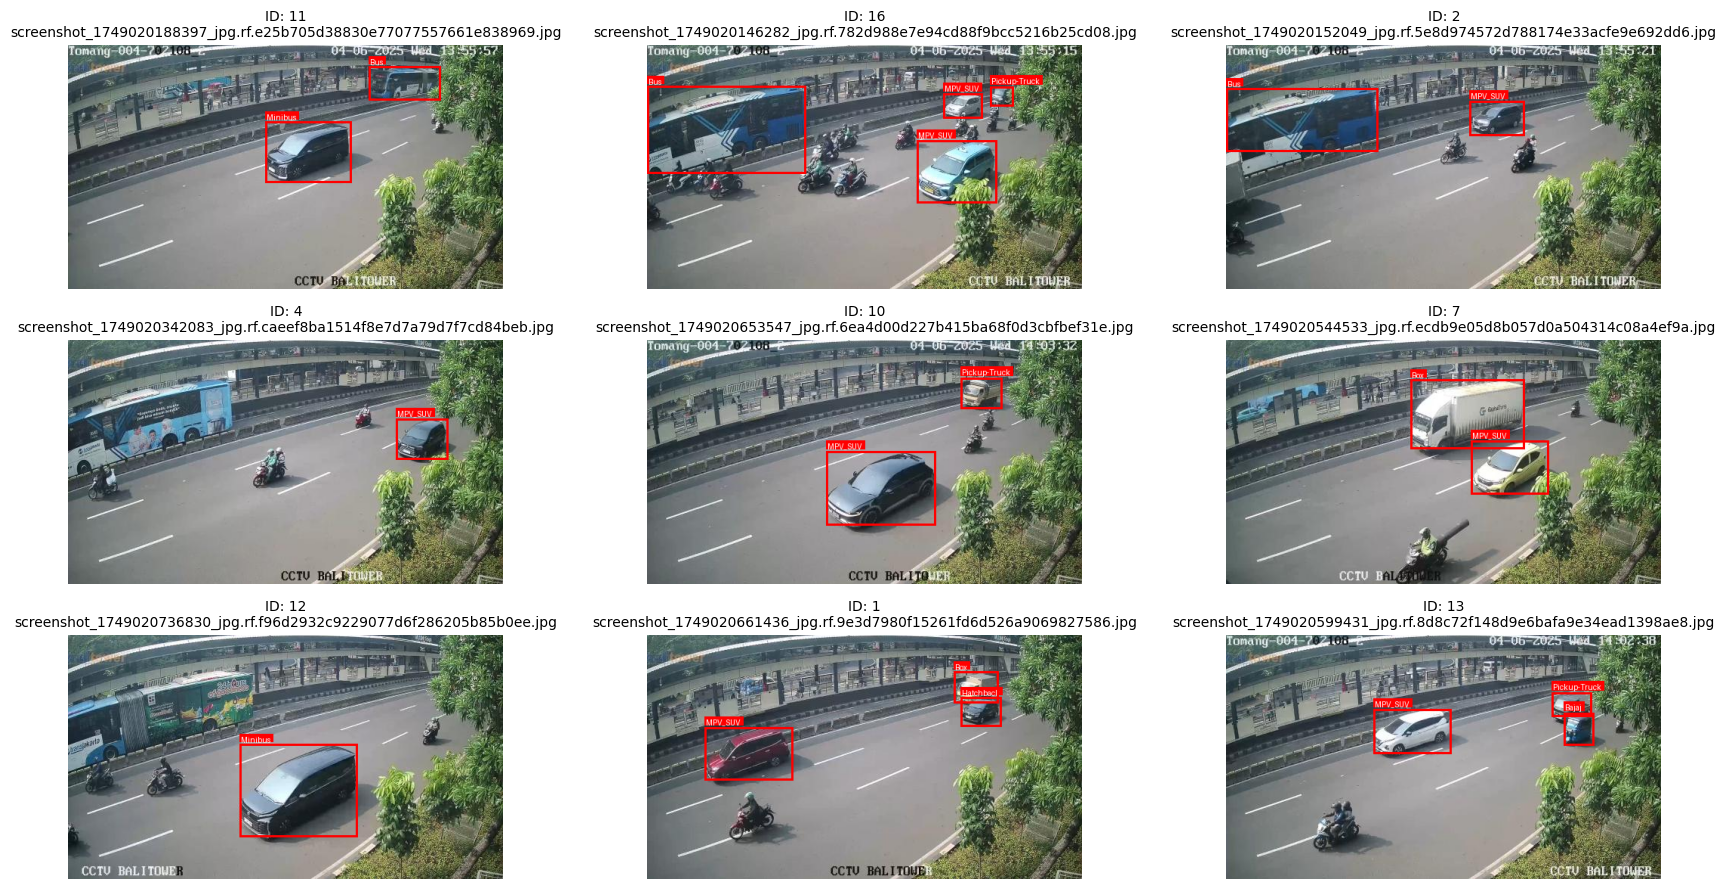


Displaying 9 sample images from test split...


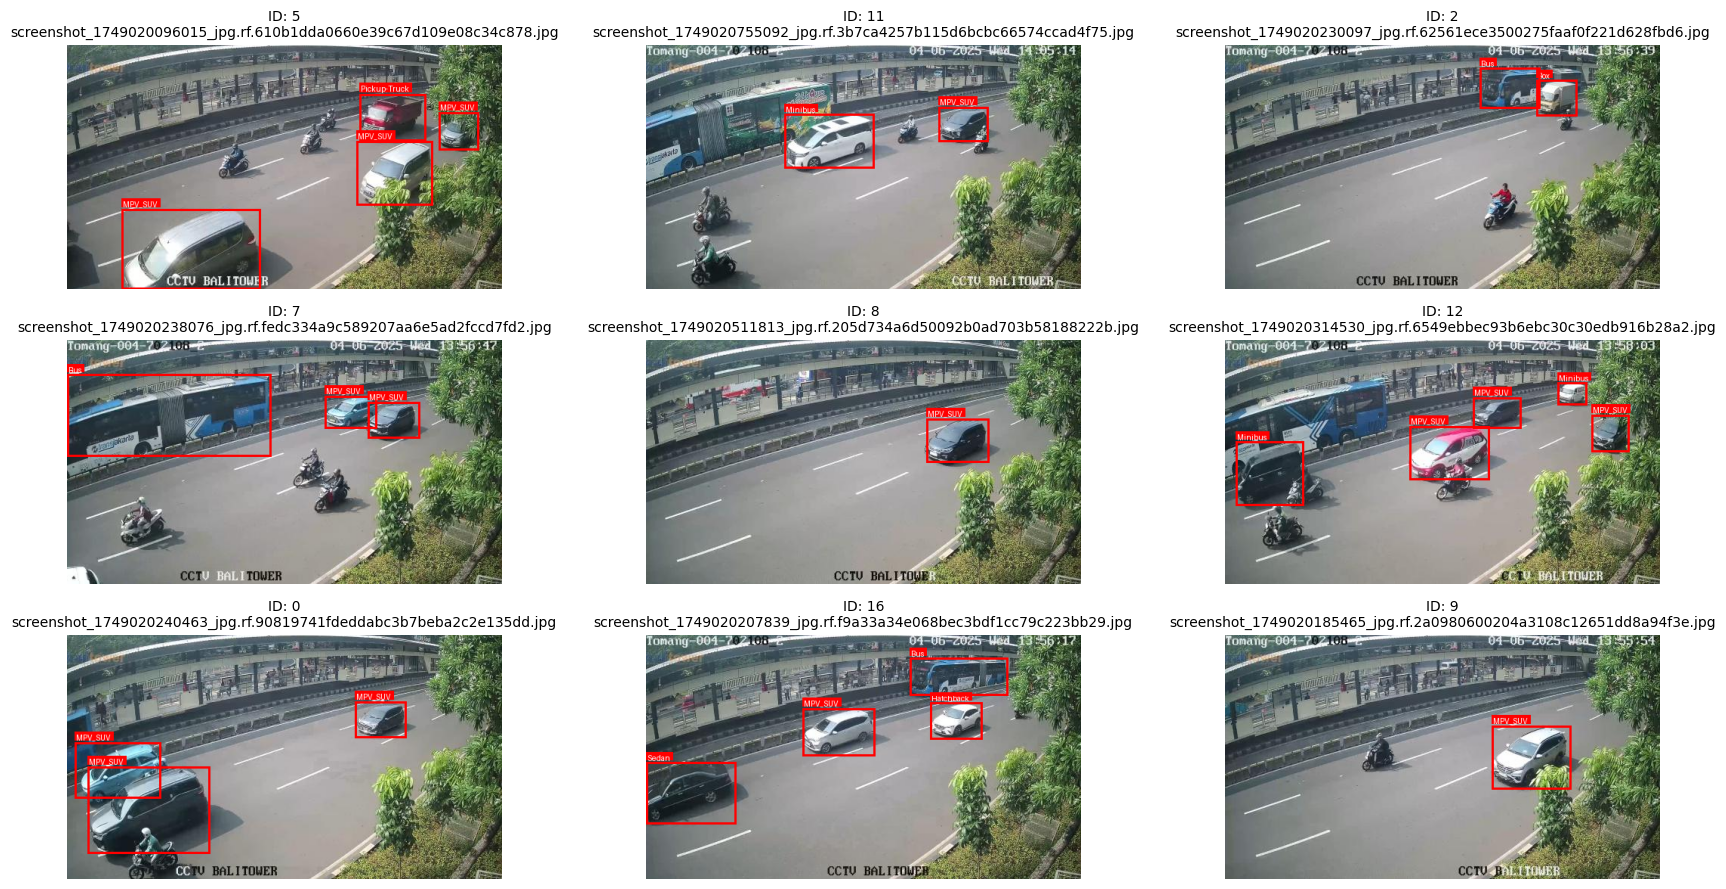

In [ ]:
print("\n--- Visualization: Sample Images with Bounding Boxes ---")

def display_sample_images(split_name, num_samples=9, images_per_row=3):
    print(f"\nDisplaying {num_samples} sample images from {split_name} split...")

    split_path = os.path.join(BASE_DATASET_PATH, split_name)
    annotations = load_coco_annotations(split_path)

    if annotations is None or not annotations['images']:
        print(f"No images or annotations found for {split_name} to display samples.")
        return

    image_id_to_anns = {}
    for ann in annotations['annotations']:
        image_id_to_anns.setdefault(ann['image_id'], []).append(ann)

    category_id_to_name = {cat['id']: cat['name'] for cat in annotations['categories']}

    images_with_anns = [img for img in annotations['images'] if img['id'] in image_id_to_anns]
    if images_with_anns:
        sample_image_infos = random.sample(images_with_anns, min(num_samples, len(images_with_anns)))
    else:
        print(f"Warning: No annotations found for any images in {split_name}. Displaying random images without boxes.")
        sample_image_infos = random.sample(annotations['images'], min(num_samples, len(annotations['images'])))

    num_rows = (len(sample_image_infos) + images_per_row - 1) // images_per_row

    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * 6, num_rows * 3))
    axes = axes.flatten()

    try:
        from PIL import ImageFont
        font = ImageFont.truetype("arial.ttf", 20)
    except IOError:
        font = ImageFont.load_default()
        print("Warning: Could not load 'arial.ttf', using default font. Text rendering might be basic.")

    for i, image_info in enumerate(sample_image_infos):
        img_id = image_info['id']
        image_filename = image_info['file_name']
        image_full_path = get_image_path(split_path, image_filename)

        if image_full_path is None or not os.path.exists(image_full_path):
            print(f"Could not load image: {image_full_path}")
            axes[i].axis('off')
            continue

        try:
            img = Image.open(image_full_path).convert("RGB")
        except Exception as e:
            print(f"Error opening image {image_full_path}: {e}")
            axes[i].axis('off')
            continue

        draw = ImageDraw.Draw(img)
        img_annotations = image_id_to_anns.get(img_id, [])

        for ann in img_annotations:
            bbox = ann['bbox'] # [x, y, width, height]
            x, y, w, h = bbox
            label = category_id_to_name.get(ann['category_id'], 'unknown')

            draw.rectangle([x, y, x + w, y + h], outline="red", width=3)

            text_bbox = draw.textbbox((x, y), label, font=font)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]

            text_x = x
            text_y = y - text_height - 5

            if text_y < 0:
                text_y = y + 5

            draw.rectangle([text_x, text_y, text_x + text_width + 5, text_y + text_height + 2], fill="red")
            draw.text((text_x + 2, text_y + 2), label, fill="white", font=font)


        axes[i].imshow(img)
        axes[i].set_title(f"ID: {img_id}\n{image_filename}", fontsize=10)
        axes[i].axis('off')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

for split in SPLITS:
    display_sample_images(split, num_samples=9)

## 4. Visualize Sample Images (Classification)

In [4]:
!./run_dataset_conversion.sh

Processing train: 100% 348/348 [00:00<00:00, 404.85it/s]
Processing valid: 100% 33/33 [00:00<00:00, 430.40it/s]
Processing test: 100% 47/47 [00:00<00:00, 436.45it/s]

Dataset verification:
Classes: ['Bajaj', 'Box', 'Bus', 'Hatchback', 'MPV_SUV', 'Minibus', 'Pickup-Truck', 'Sedan']
train: 348 images
valid: 33 images
test: 47 images

Conversion complete!


--- Displaying 16 Sample Images from Classification Dataset ---
Found 8 categories: Bajaj, Box, Bus, Hatchback, MPV_SUV, Minibus, Pickup-Truck, Sedan


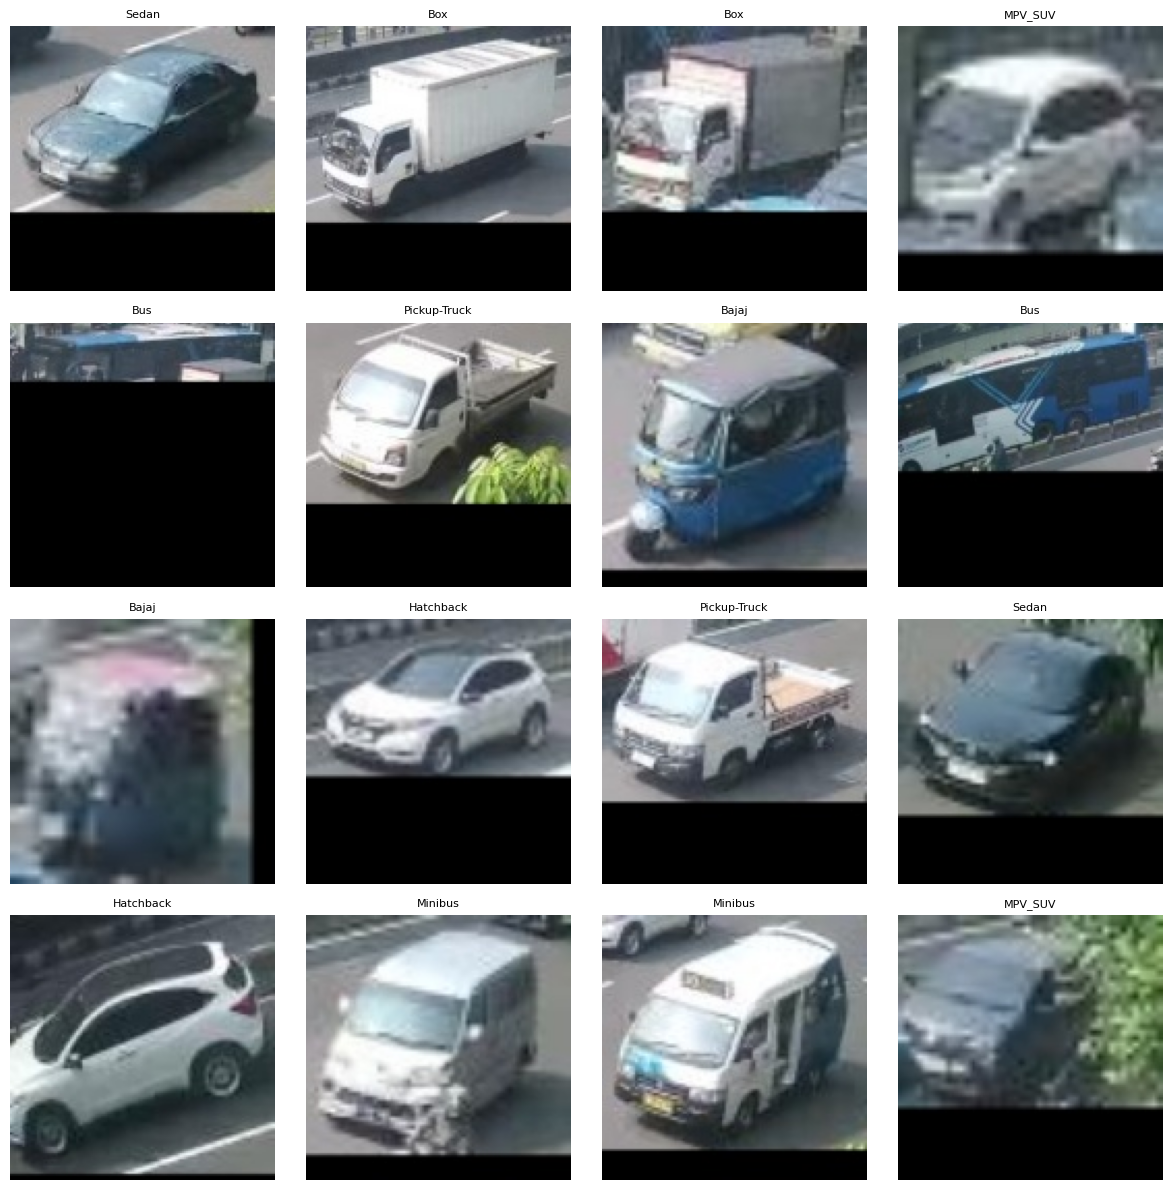


Sample image display complete.


In [8]:
import os
import random
import matplotlib.pyplot as plt
import math
from PIL import Image

DATASET_PATH = 'data/classification/train'

NUM_SAMPLES = 16

def display_classification_samples(dataset_path, num_samples=16):
    print(f"--- Displaying {num_samples} Sample Images from Classification Dataset ---")

    categories = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    categories.sort()

    if not categories:
        print(f"Error: No category subfolders found in {dataset_path}")
        return

    print(f"Found {len(categories)} categories: {', '.join(categories)}")

    all_image_paths = []
    category_image_paths = {cat: [] for cat in categories}

    for category in categories:
        category_path = os.path.join(dataset_path, category)
        for root, _, files in os.walk(category_path):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
                    img_path = os.path.join(root, file)
                    all_image_paths.append((img_path, category))
                    category_image_paths[category].append(img_path)

    if not all_image_paths:
        print(f"Error: No images found in {dataset_path} or its subfolders.")
        return

    grid_cols = int(math.ceil(math.sqrt(num_samples)))
    grid_rows = int(math.ceil(num_samples / grid_cols))

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 3, grid_rows * 3))
    axes = axes.flatten()

    sampled_image_infos = []
    if len(categories) > 0:
        samples_per_category = math.ceil(num_samples / len(categories))
        for category in categories:
            num_to_sample = min(samples_per_category, len(category_image_paths[category]))
            sampled_paths = random.sample(category_image_paths[category], num_to_sample)
            for img_path in sampled_paths:
                sampled_image_infos.append((img_path, category))
                if len(sampled_image_infos) >= num_samples:
                    break
            if len(sampled_image_infos) >= num_samples:
                break
    else:
        sampled_image_infos = random.sample(all_image_paths, min(num_samples, len(all_image_paths)))

    random.shuffle(sampled_image_infos)
    sampled_image_infos = sampled_image_infos[:num_samples]

    for i, (img_path, category_name) in enumerate(sampled_image_infos):
        if i >= num_samples:
            break

        try:
            img = Image.open(img_path).convert('RGB')
            axes[i].imshow(img)
            axes[i].set_title(f"{category_name}", fontsize=8)
            axes[i].axis('off')
        except Exception as e:
            print(f"Could not load or display {img_path}: {e}")
            axes[i].set_title(f"Error: {category_name}", fontsize=8)
            axes[i].axis('off')

    for j in range(len(sampled_image_infos), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

display_classification_samples(DATASET_PATH, NUM_SAMPLES)

print("\nSample image display complete.")